In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import re
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
import warnings
from transformers import pipeline, AutoTokenizer
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

# Project


# Dataset Cleaning Tweets


In [6]:
from bs4 import BeautifulSoup
import unicodedata
import re
import emoji
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import logging
from typing import List, Dict, Optional, Union
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import time
from pathlib import Path

In [7]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('data_processing.log'),
        logging.StreamHandler()
    ]
)

In [8]:
class TweetPreprocessor:
    """Class to handle tweet preprocessing with robust error handling and validation."""
    
    def __init__(self):
        self.emoticon_map = {
            r':\)|:-\)|\(-:|\(:': '[emoticon:happy]',
            r':\(|:-\(|\)-:|\):': '[emoticon:sad]',
            r';\)|;-\)': '[emoticon:wink]',
            r':D|:-D': '[emoticon:laugh]',
        }
        
    @staticmethod
    def safe_eval_hashtags(x: Union[str, List[str], None]) -> List[str]:
        """Safely evaluate hashtag strings."""
        try:
            if isinstance(x, str) and x.startswith('['):
                return eval(x)
            elif isinstance(x, list):
                return x
            return []
        except:
            return []

    def process_emojis(self, text: str) -> str:
        """Process emojis and emoticons in text."""
        if not isinstance(text, str):
            return ""

        # Process emoticons
        for pattern, label in self.emoticon_map.items():
            text = re.sub(pattern, label, text)

        # Process emojis
        try:
            return emoji.demojize(text, delimiters=("[emoji:", "]"))
        except:
            return text

    def clean_text(self, text: str) -> str:
        """Clean and normalize text content."""
        if not isinstance(text, str) or pd.isna(text):
            return ""
            
        # Remove HTML
        text = BeautifulSoup(text, 'html.parser').get_text()
        
        # Normalize unicode
        text = unicodedata.normalize('NFKD', text)
        
        # Process emojis
        text = self.process_emojis(text)
        
        # Remove URLs, mentions, and special characters
        text = re.sub(r'http\S+|@\w+|[^\w\s#\U0001F300-\U0001F6FF]', '', text)
        
        # Normalize whitespace
        text = ' '.join(text.split())
        
        return text

    def preprocess_chunk(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess a chunk of tweets with validation and error handling."""
        try:
            df = df.copy()
            
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'], errors='coerce')
                df = df[df['date'].notna()]
                df['date'] = df['date'].dt.normalize()
            
            available_cols = [col for col in ['text', 'hashtags', 'user_followers', 'date', 'is_retweet']
                         if col in df.columns]
            df = df[available_cols].copy()
            
            for col in ['text', 'hashtags', 'is_retweet']:
                if col not in df.columns:
                    df[col] = "" if col == 'text' else [] if col == 'hashtags' else False
            
            df['text'] = df['text'].astype(str)
            df['text'] = df['text'].apply(self.clean_text)
            
            df['hashtags'] = df['hashtags'].apply(self.safe_eval_hashtags)
            
            if 'is_retweet' in df.columns:
                df['is_retweet'] = pd.to_numeric(df['is_retweet'], errors='coerce').fillna(0).astype(bool)
                df = df[~df['is_retweet']].drop(columns=['is_retweet'], errors='ignore')
            
            df['text_length'] = df['text'].str.len()
            df['hashtag_count'] = df['hashtags'].str.len()
            
            df = df[df['text_length'] > 0]
            
            return df
            
        except Exception as e:
            logging.error(f"Error preprocessing chunk: {str(e)}")
            raise

In [9]:
class DataLoader:
    """Class to handle data loading and processing with batched writes."""
    
    def __init__(self, preprocessor: TweetPreprocessor):
        self.preprocessor = preprocessor
        self.accumulated_df = None
        
    def process_chunk(self, chunk: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Process a single chunk with error handling."""
        try:
            if len(chunk) == 0:
                return None
            return self.preprocessor.preprocess_chunk(chunk)
        except Exception as e:
            logging.error(f"Error processing chunk: {str(e)}")
            return None

    def _write_batch(self, chunks: List[pd.DataFrame], output_path: str) -> None:
        """Write a batch of chunks to parquet file."""
        if not chunks:
            return
            
        combined_df = pd.concat(chunks, ignore_index=True)
        
        # Accumulate data in memory
        if self.accumulated_df is None:
            self.accumulated_df = combined_df
        else:
            self.accumulated_df = pd.concat([self.accumulated_df, combined_df], ignore_index=True)
        
        # Write accumulated data to file
        try:
            self.accumulated_df.to_parquet(output_path)
            logging.info(f"Successfully wrote {len(self.accumulated_df)} total rows to {output_path}")
        except Exception as e:
            logging.error(f"Error writing to parquet file: {str(e)}")
            # Save to backup file if main save fails
            backup_path = output_path.replace('.parquet', f'_backup_{int(time.time())}.parquet')
            self.accumulated_df.to_parquet(backup_path)
            logging.info(f"Wrote backup file to {backup_path}")

    def load_and_process(self, 
                        file_path: str, 
                        output_path: str,
                        chunksize: int = 50000,
                        batch_size: int = 5,
                        max_retries: int = 3) -> bool:
        """Load and process data with batched writes."""
        start_time = time.time()
        processed_chunks = []
        retry_chunks = []
        
        try:
            Path(output_path).parent.mkdir(parents=True, exist_ok=True)
            
            chunk_iter = pd.read_csv(
                file_path,
                chunksize=chunksize,
                engine='python',
                on_bad_lines='warn',
                quoting=3
            )
            
            for i, chunk in enumerate(tqdm(chunk_iter, desc="Processing chunks")):
                try:
                    processed_chunk = self.process_chunk(chunk)
                    if processed_chunk is not None:
                        processed_chunks.append(processed_chunk)
                    
                    if len(processed_chunks) >= batch_size:
                        self._write_batch(processed_chunks, output_path)
                        processed_chunks = []
                        
                except Exception as e:
                    logging.error(f"Error processing chunk {i}: {str(e)}")
                    retry_chunks.append((i, chunk))
            
            # Write any remaining chunks
            if processed_chunks:
                self._write_batch(processed_chunks, output_path)
            
            if retry_chunks and max_retries > 0:
                self._handle_retries(retry_chunks, output_path, max_retries)
            
            elapsed_time = time.time() - start_time
            logging.info(f"Processing completed in {elapsed_time:.2f} seconds")
            return True
            
        except Exception as e:
            logging.error(f"Fatal error: {str(e)}")
            return False
    
    def _handle_retries(self, retry_chunks: List[tuple], output_path: str, max_retries: int) -> None:
        """Handle retry attempts for failed chunks."""
        for attempt in range(max_retries):
            if not retry_chunks:
                break
                
            logging.info(f"Retry attempt {attempt + 1} for {len(retry_chunks)} chunks")
            still_failed = []
            
            for chunk_id, chunk in retry_chunks:
                try:
                    processed_chunk = self.process_chunk(chunk)
                    if processed_chunk is not None:
                        self._write_batch([processed_chunk], output_path)
                except Exception as e:
                    logging.error(f"Retry failed for chunk {chunk_id}: {str(e)}")
                    still_failed.append((chunk_id, chunk))
            
            retry_chunks = still_failed

In [10]:
# Initialize the preprocessor and loader
preprocessor = TweetPreprocessor()
loader = DataLoader(preprocessor)

# Process the data
success = loader.load_and_process(
    file_path="Bitcoin_tweets.csv",
    output_path="bitcoin_cleaned.parquet",
    chunksize=50000,
    batch_size=5,
    max_retries=3
)

if success:
    logging.info("Data processing completed successfully")
else:
    logging.error("Data processing failed")

Processing chunks: 4it [00:01,  3.98it/s]2025-04-27 19:48:54,734 - INFO - Successfully wrote 37 total rows to bitcoin_cleaned.parquet
Processing chunks: 9it [00:02,  4.00it/s]2025-04-27 19:48:55,808 - INFO - Successfully wrote 80 total rows to bitcoin_cleaned.parquet
Processing chunks: 14it [00:03,  3.46it/s]2025-04-27 19:48:57,249 - INFO - Successfully wrote 114 total rows to bitcoin_cleaned.parquet
Processing chunks: 19it [00:05,  3.94it/s]2025-04-27 19:48:58,508 - INFO - Successfully wrote 140 total rows to bitcoin_cleaned.parquet
Processing chunks: 24it [00:06,  3.64it/s]2025-04-27 19:48:59,851 - INFO - Successfully wrote 148 total rows to bitcoin_cleaned.parquet
Processing chunks: 29it [00:07,  3.75it/s]2025-04-27 19:49:01,096 - INFO - Successfully wrote 182 total rows to bitcoin_cleaned.parquet
Processing chunks: 34it [00:08,  4.38it/s]2025-04-27 19:49:02,217 - INFO - Successfully wrote 192 total rows to bitcoin_cleaned.parquet
Processing chunks: 39it [00:09,  4.55it/s]2025-04-27

In [11]:
df = pd.read_parquet("/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/bitcoin_cleaned.parquet")

print("Basic Stats:")
print(df.describe())

Basic Stats:
                             date  text_length  hashtag_count
count                        1125  1125.000000    1125.000000
mean   2020-04-03 18:57:55.200000    66.343111       0.430222
min           1685-01-01 00:00:00     3.000000       0.000000
25%           2021-08-09 00:00:00    29.000000       0.000000
50%           2021-11-18 00:00:00    52.000000       0.000000
75%           2022-05-12 00:00:00    84.000000       1.000000
max           2070-01-01 00:00:00   591.000000       1.000000
std                           NaN    55.461519       0.495327


In [12]:
# Convert date column to datetime and clean the dates
df['date'] = pd.to_datetime(df['date'])

# Filter for realistic dates (2018-2023)
df = df[
    (df['date'].dt.year >= 2018) & 
    (df['date'].dt.year <= 2023)
].copy()

print("Dataset after date cleaning:")
print("Number of tweets:", len(df))
print("\nDate range:")
print("Start date:", df['date'].min())
print("End date:", df['date'].max())

Dataset after date cleaning:
Number of tweets: 1103

Date range:
Start date: 2018-01-01 00:00:00
End date: 2023-01-09 00:00:00


### EDA-Tweets

In [13]:
# Create daily tweet aggregation with cleaned data
daily_tweets = df.groupby('date').size().reset_index(name='tweet_count')

# Print daily tweet statistics
print("Daily tweet statistics:")
print(daily_tweets['tweet_count'].describe())

Daily tweet statistics:
count    193.000000
mean       5.715026
std        5.134304
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       29.000000
Name: tweet_count, dtype: float64


Text(0, 0.5, 'Count')

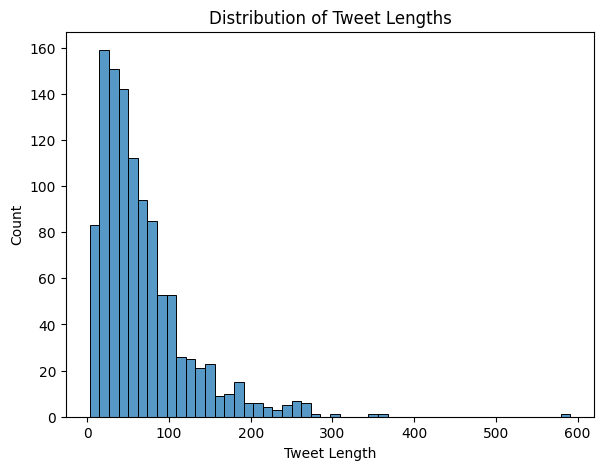

In [14]:
    # Plot tweet length distribution
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='text_length', bins=50)
    plt.title('Distribution of Tweet Lengths')
    plt.xlabel('Tweet Length')
    plt.ylabel('Count')

Text(0, 0.5, 'Number of Tweets')

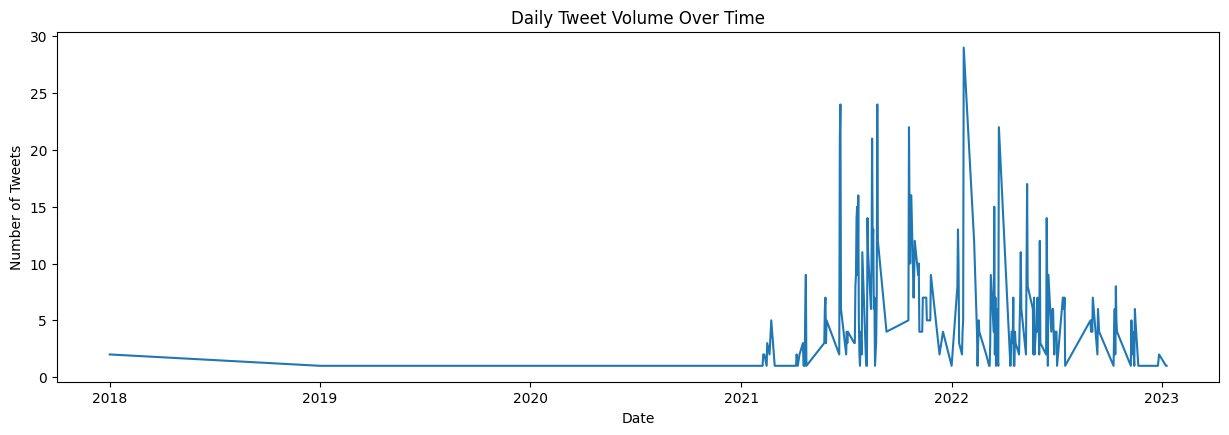

In [15]:
    # Plot daily tweet counts
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(daily_tweets['date'], daily_tweets['tweet_count'])
    plt.title('Daily Tweet Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Tweets')

# Data Bitcoin Prices

In [16]:
import yfinance as yf
import pandas as pd

# Fetch historical Bitcoin prices
def get_btc_prices(start_date='2018-01-01', end_date='2023-12-31'):
    btc = yf.Ticker("BTC-USD")
    df = btc.history(start=start_date, end=end_date)
    return df[['Close', 'Volume']].rename(columns={'Close': 'price'})

# Sentiment Analysis

In [17]:
tokenizer = AutoTokenizer.from_pretrained('ElKulako/cryptobert')
model = AutoModelForSequenceClassification.from_pretrained('ElKulako/cryptobert')
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def batch_sentiment(texts, batch_size=32):
    sentiments = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        results = sentiment_pipeline(batch)
        sentiments.extend(results)
    return sentiments

Device set to use mps:0


In [18]:
# Apply sentiment analysis
sentiments = batch_sentiment(df['text'].tolist())
df['sentiment'] = [s['label'] for s in sentiments]
df['sentiment_score'] = [s['score'] for s in sentiments]

# Sentiment Aggregation

In [19]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date']).dt.normalize()


In [20]:
# Aggregate daily sentiment
daily_sentiment = df.groupby('date').agg({
    'sentiment': lambda x: (x == 'positive').mean(),
    'sentiment_score': 'mean'
}).reset_index()

print(daily_sentiment.head())

        date  sentiment  sentiment_score
0 2018-01-01        0.0         0.519679
1 2019-01-01        0.0         0.462780
2 2021-02-05        0.0         0.794075
3 2021-02-07        0.0         0.481316
4 2021-02-08        0.0         0.555911


In [21]:
# Load the data and inspect the date column
df = pd.read_parquet('bitcoin_cleaned.parquet')
print("Unique values in date column:")
print(df['date'].unique())
print("\nSample of date values:")
print(df['date'].head(10))
print("\nDataFrame info:")
print(df.info())

Unique values in date column:
<DatetimeArray>
['2021-02-10 00:00:00', '2021-02-09 00:00:00', '2021-02-08 00:00:00',
 '2021-02-07 00:00:00', '1831-01-01 00:00:00', '2021-02-05 00:00:00',
 '2021-02-15 00:00:00', '2021-02-14 00:00:00', '1853-01-01 00:00:00',
 '1928-01-01 00:00:00',
 ...
 '2049-01-01 00:00:00', '2022-11-16 00:00:00', '2022-11-15 00:00:00',
 '2022-11-14 00:00:00', '2022-11-21 00:00:00', '2022-12-27 00:00:00',
 '2022-12-25 00:00:00', '2023-01-09 00:00:00', '1988-01-01 00:00:00',
 '2023-01-08 00:00:00']
Length: 211, dtype: datetime64[ns]

Sample of date values:
0   2021-02-10
1   2021-02-10
2   2021-02-09
3   2021-02-09
4   2021-02-08
5   2021-02-08
6   2021-02-07
7   1831-01-01
8   1831-01-01
9   1831-01-01
Name: date, dtype: datetime64[ns]

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   text  

## Data Integration

In [22]:
# Get price data
price_df = get_btc_prices()

# Convert price_df index to naive datetime to match daily_sentiment
price_df.index = price_df.index.tz_localize(None)

# Merge datasets
merged_df = pd.merge(
    daily_sentiment,
    price_df,
    left_on='date',
    right_index=True,
    how='inner'
)

# Create target variable (next day's price movement)
merged_df['price_change'] = merged_df['price'].pct_change().shift(-1)

In [23]:
print(merged_df.columns)

Index(['date', 'sentiment', 'sentiment_score', 'price', 'Volume',
       'price_change'],
      dtype='object')


In [24]:
def trading_strategy(df, threshold=0.5):
    """Generate trading signals based on sentiment thresholds"""
    df['signal'] = 'HOLD'
    df.loc[df['sentiment'] > threshold, 'signal'] = 'BUY'  
    df.loc[df['sentiment'] < -threshold, 'signal'] = 'SELL'  
    return df
# Apply strategy
strategy_df = trading_strategy(merged_df.copy())

In [25]:
"""
## Part 6: Backtesting System ✅
### Portfolio Simulation
"""
# %%
def backtest(df, initial_capital=10000):
    capital = initial_capital
    position = 0
    portfolio = []
    
    for _, row in df.iterrows():
        current_price = row['price']
        
        if row['signal'] == 'BUY' and capital > 0:
            position = capital / current_price
            capital = 0
            
        elif row['signal'] == 'SELL' and position > 0:
            capital = position * current_price
            position = 0
            
        portfolio_value = capital + (position * current_price)
        portfolio.append(portfolio_value)
    
    df['portfolio'] = portfolio
    return df

# Run backtest
results_df = backtest(strategy_df)


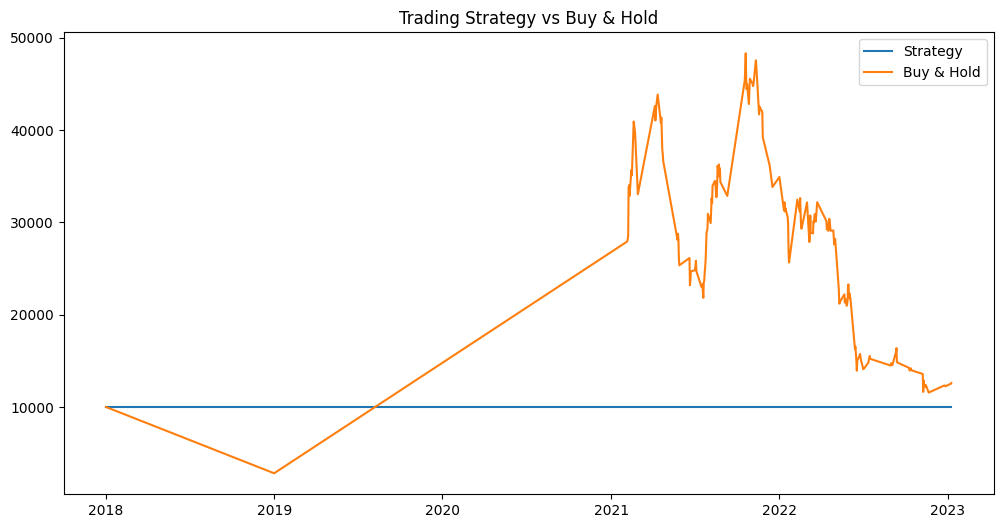

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(results_df['date'], results_df['portfolio'], label='Strategy')
plt.plot(results_df['date'], results_df['price']/results_df['price'].iloc[0]*10000, label='Buy & Hold')
plt.title('Trading Strategy vs Buy & Hold')
plt.legend()
plt.show()


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import TimeSeriesSplit

In [29]:
# Feature engineering
def create_features(df):
    df['price_ma7'] = df['price'].rolling(7).mean()
    df['sentiment_ma3'] = df['sentiment'].rolling(3).mean()
    df['volume_change'] = df['Volume'].pct_change()
    return df.dropna()

In [30]:
# Prepare ML dataset
ml_df = create_features(merged_df.copy())
features = ['sentiment', 'price_ma7', 'sentiment_ma3', 'volume_change']


In [31]:
# Create binary target: 1 if price goes up, 0 if price goes down
ml_df['target'] = (ml_df['price_change'] > 0).astype(int)

# Time-series cross-validation
tss = TimeSeriesSplit(n_splits=5)
X = ml_df[features]
y = ml_df['target']

In [32]:
# Model training
best_model = None
best_score = 0

for train_idx, test_idx in tss.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    if f1 > best_score:
        best_score = f1
        best_model = model

print(f"Best Model F1 Score: {best_score:.2f}")

Best Model F1 Score: 0.72
